In [452]:
#!pip install ruptures


In [453]:
NORUPTURES = False
try:
    import ruptures as rpt
except ModuleNotFoundError:
    print("WARNING: installation of raptures failed - movoing on without raptures analysis")
    NORUPTURES = True
import pylab as plt
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.optimize import minimize
import os

%matplotlib inline

In [454]:
#Move up to RAFTS directory
if os.getcwd().endswith('/RAFTS'):
    pass
else:
    os.chdir('..')


In [455]:

from utils import filt_interp, dpar, dtan, lamb_eff_md, dcr_offset, celest_to_pa, inverse_Teff, inverseTeff, inverseWeff, lorentzian, find_min_max_adjacent, variance_weighted_mean, chrDistAng
import globals

from config import *

os.chdir(globals.ROOTDIR)
start = 8
end = 82

In [456]:
!pwd

/Users/fbianco/RAFTS


# data

In [457]:
#flare = pd.read_csv("Outdata/dwf30225_545707_dpar.csv")#, names=["mjd", "dpar_detrended")
flare = pd.read_csv("Outdata/flare_df.csv")#, names=["mjd", "dpar_detrended")
flare = flare.sort_values(by="mjd")
flare = flare.iloc[start:end]

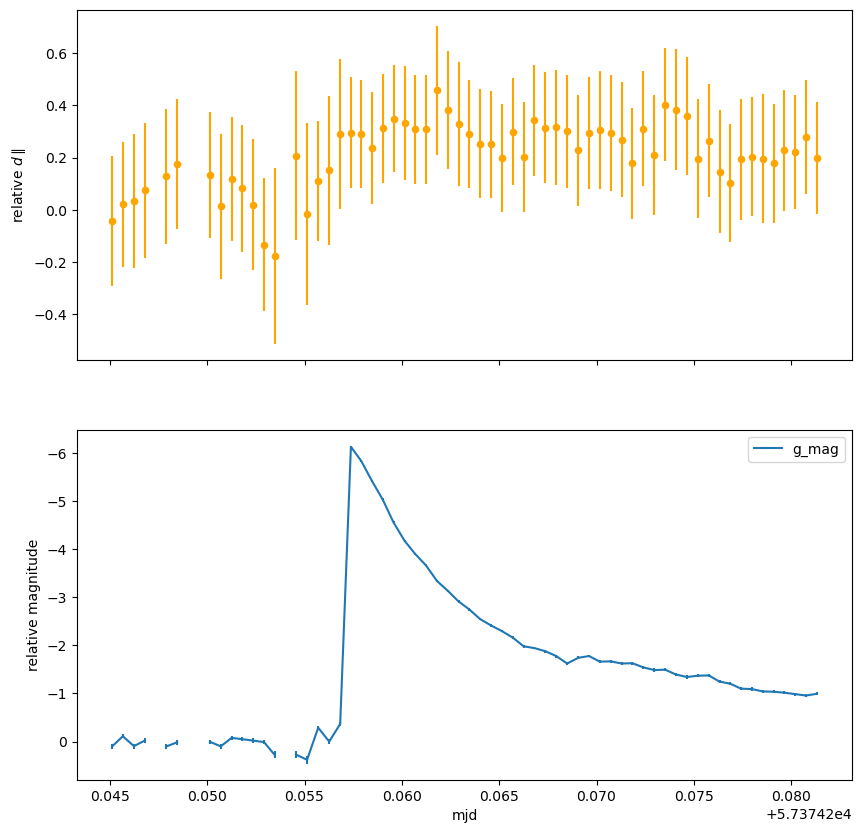

In [458]:
fig, axs = plt.subplots(2, 1, figsize=(10,10), sharex=True)
ax0 = flare.plot("mjd", "dpar_detrended", kind="scatter", yerr="dpar_detrended_err", ax=axs[0], color="orange")
ax0.set_ylabel(r"relative $d\parallel$")

ax1 = flare.plot("mjd", "g_mag", yerr="g_mag_error", ax=axs[1])
ax1.set_ylabel("relative magnitude")
ax1.invert_yaxis()

### Here we perform a statistical analysis of the existence of a statistically significant behaviour change in the time series of zenithward angle for the flaring star. 

### We demonstrate that the point if change exists, to a statistical significance of 5 sigma, which is to say a behavior as extreme as that  observed in the time series of $d\parallel$, the zenithward angle of the flaring star, has a 1 in 3.5 million chances of occurring by chance (note that the standard in astrophsyical data analysis is typically 3-sigma, or 1 in 997 chances of occurring by chance). 

## We identify the location of the point of change (POC) and assess its statistical significance, with different methods, to ensure the reader (or the referee) has no further doubts about our claim of an incredibly solid detection.

# chi square to a horizontal line

### NOTE: this analysis is the incorrect approach as described below! however, we include this naive test since it was what the referee implicitly suggested by claiming that the 1-2 sigma consistency of the points in the series implies no statistically robust detection. The key mistake here is that this apporoach implied the points are drawn from a IID and are independent, which of course they are not


In [459]:
chi2 = sum((flare["dpar_detrended"] - flare["dpar_detrended"].mean())**2 / flare["dpar_detrended_err"]**2) / (len(flare) - 1)
print("Chi2 with a horizontal line model with mean the mean of the entire dataset\n"
"(what the referee suggested matters): {:.2f}".format(chi2))

Chi2 with a horizontal line model with mean the mean of the entire dataset
(what the referee suggested matters): 0.25


this demonstrates that the uncertainties are overestimated, which we knew and can see by comparing them with the scatter of the data altogether: the bootstrap method we used to measure uncertainties does overestimate the uncertainties, we had clarified and included a discussion of the bootstrap uncertainty derivation in our manuscript. We show the uncertainties for completeness.

In [460]:
chi2_earlymean = sum((flare["dpar_detrended"] - flare.iloc[:20]["dpar_detrended"].mean())**2 / flare["dpar_detrended_err"]**2) / (len(flare) - 1)
print("Chi2 with a horizontal line model with mean the mean of the first 20 data points before the flare: {:.2f}".format(chi2_earlymean))

Chi2 with a horizontal line model with mean the mean of the first 20 data points before the flare: 0.84


Even under the assumption of a IID points, in fact, the typical uncertainty (mean of errors) is larger than the scatter in the data

In [461]:
print("Mean error {:.2f} | Standard deviation of the data {:.2f}".format(flare["dpar_detrended_err"].mean(), flare["dpar_detrended"].std()))

Mean error 0.23 | Standard deviation of the data 0.13


### Regardless of the overestimation of the uncertainties, this is the wrong test: it assumes all points in the time series are IID which is obviously the wrong assumption since this is a series and the order matters!

# POINT OF CHANGE ANALYSIS (POC) - the right analysis to do

point of change analysis is a statistical framework to identify behavior changes in (time) series. A number of methods are described in this framework, we will test a few. Specifically we will use a few different methods to _identify_ the position of a point of change in the time series (under the assumption of 1 point of change to simplify the analysis) and we will use both frequentist and Bayesian methods to assess the significance of a point-of-change model compared to a stationary model (i.e. no point of change, no change in the property of the distribution the data comes from).

Generally, POC analysis tries to minimize (for m segments)

$$ \sum_{i=1}^{m+1} C(y[t_{i-1}:t_i]) + f(m) $$

where C is a cost function calculated for each segment and f(m) is a function of the number of segments: a regularizatoin introduced to avoid overfitting.

Since we are only interested in 1 POC, we will generally ignore any solution with m>1 and, where possible, impose a single POC solution



#### However, this is a naive method and, from the plot above, it is clear that it is sensitive to the significant scatter in the time series. 

## Minimizind difference between means and associated model $\chi^2$

In [462]:
def chi2(a, b, e):
    """
    Return the square error between data points and a model

    Input:
      a: array of data points
      b: array of model points

    Output:
      square error: the square error between the data and the model
    """
    return np.sum((a - b)**2 / e**2)


def poc_mse(y, yerr):
    """
    Find the POC by assuming a single POC and minimizing the square error, as well as
    maximizing the difference in the means before and after the POC.

    Input:
      y: array of data for the endogenous variable

    Output:
      poc: index of the point of change
      before: mean before the point of change
      after: mean after the point of change
    """

    N = len(y)
    f = np.nanmean
    poc, diff, se, before, after = 0, 0, 1_000_000, np.nan, np.nan
    # This will find the state of change by maximizing the difference between the means before and after the poc

    for i in range(5, N-5):
        diff_here = np.abs(f(y[i:]) -  f(y[:i])) #difference between means before and after
        if diff < diff_here: #brute force minimization
            diff_g = diff_here
            poc_g = i
            before_g, after_g= f(y[:i]), f(y[i:]) #means before and after

            # create a 2 component step function model based on the point of the change determined here
            y_model = [before_g] * poc_g + [after_g] * (len(y) - poc_g)
            # find the square error of this model
            se_here = chi2(y, y_model, yerr)
            #print(se_here)

            # if the squared error is smaller here, set the variables to be what it is at this point
            if se_here < se:
                se = se_here
                poc, before, after = poc_g, before_g, after_g
                diff = diff_g

    return(poc, before, after)

poc2, beforepoc, afterpoc = poc_mse(flare["dpar_detrended"], flare["dpar_detrended_err"])
poc2 += 5
y_model = [beforepoc] * poc2 + [afterpoc] * (N - poc2)
print(f"POC found by minimizind difference between means and associated model chi2 at {poc2}")



POC found by minimizind difference between means and associated model chi2 at 21


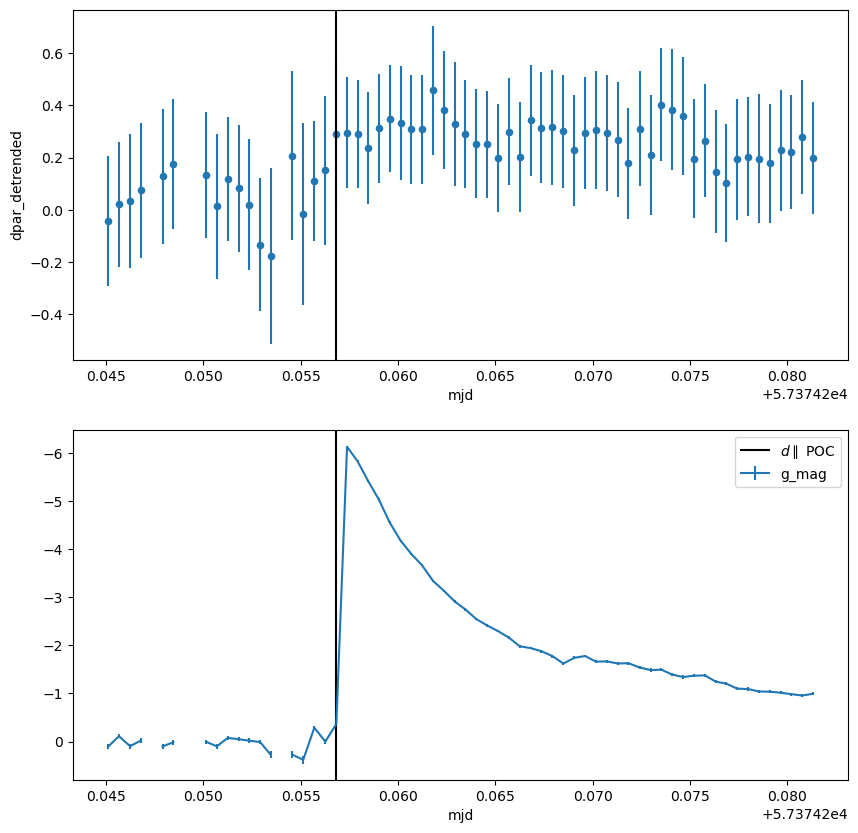

In [463]:
poc = poc2
fig, axs = plt.subplots(2, 1, figsize=(10,10))
flare.plot("mjd", "dpar_detrended", kind="scatter", yerr="dpar_detrended_err", ax=axs[0])
axs[0].axvline(flare.iloc[poc]["mjd"], color='k', label=r"$d\parallel$ POC")
ax1 = flare.plot(x="mjd", y="g_mag", yerr="g_mag_error", ax=axs[1])
ax1.invert_yaxis()
axs[1].axvline(flare.iloc[poc]["mjd"], color='k', label=r"$d\parallel$ POC")
plt.legend()


#### Not only this method is more correct methodologically, but it identifiws the POC in $d\parallel$ at what appears to be the beginning of the flare in magnitude

### We can minimize a loss function representing L2 with a gradient descent method

In [464]:
def loss_function(k, y):
  # The loss function needs to return a single scalar value
  # Let's use the sum of squared errors around the means
  #print(k)
  k = np.round(k * 1e7).astype(int)[0] # Ensure k is an integer
  if k < 1 or k >= len(y):
      return np.inf # Return a large value if k is out of bounds
  #print(k)
  error1 = (y[:k] - np.nanmean(y[:k]))**2
  #print(error1)
  error2 = (y[k:] - np.nanmean(y[k:]))**2
  #print(error2)
  error = np.nansum(error1) + np.nansum(error2)
  #print(error)
  return error

# We need an initial guess for k. Let's pick the middle index.
ig = int((flare["dpar_detrended"].shape[0] // 2))

print("initial guess", ig)
ig = ig * 1e-7
res = minimize(loss_function, ig,
                        method="Nelder-Mead", bounds=[[0,70e-7]], args=(flare["dpar_detrended"].values))
poc = (res.x * 1e7).astype(int)[0]
print(f"We find the most likely point of change is at index {poc}")
if poc == poc2:
    print("With two different methods we find the same POC")


initial guess 33
We find the most likely point of change is at index 21
With two different methods we find the same POC


In [465]:
print(f'The most likely point of change (POC) is found at MJD {flare.iloc[poc]["mjd"]}')

The most likely point of change (POC) is found at MJD 57374.25683197735


# With a candidate POC we can run statistical tests to assess its significance.


## Generative data model
In order to test the significance of the POC we need to establish a generative model for the data. For simplicity, we use a stationary Gaussian model, and a piece-wise Gaussian stationary model with mean consistent with the segment mean and stadard deviation derived from both the uncertainty and the data scatter (since we know the uncertainties are overestimated). We do not imply to argue that the true generative model for the data during the flare is a stationary process, but this is a conservative approach, since ignoring the physically motivated $d\parallel$ evolution after the start would have an even higher likelihood compared to the former

Chi2 of the step-function model with early and late average stationary states 0.11


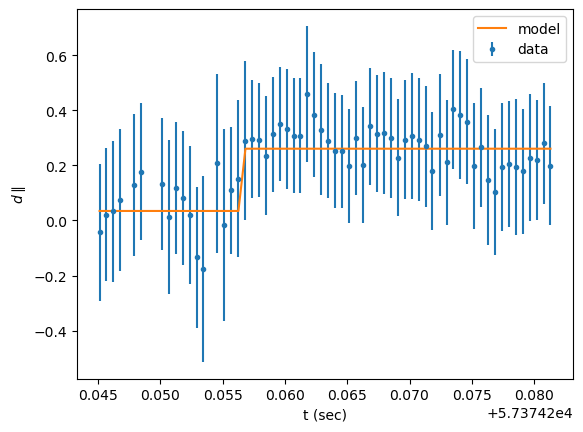

In [466]:
chi2_poc = chi2(flare["dpar_detrended"], y_model, flare["dpar_detrended_err"]) / (N-1)
print("Chi2 of the step-function model with early and late average stationary states {:.2g}".format(chi2_poc))


plt.errorbar(x=flare["mjd"], y=flare["dpar_detrended"], yerr=flare["dpar_detrended_err"], fmt='.', label="data")
plt.plot(flare["mjd"], y_model, label="model")
plt.xlabel('t (sec)')
plt.ylabel(r'$d\parallel$')
plt.legend();

### Mann-Whitney U test 

Start with a simple frequentist test: the Mann-Whitney U test is a nonparametric test of the null hypothesis
that the distribution underlying sample `x` is the same as the
distribution underlying sample `y`. It is often used as a test of
difference in location between distributions.


In [467]:
# prompt: perform a Mann-Whitney U Test on the first 23 datapoints of the flare dp and the rest of the time series

def mwtest(a, b):
  # Perform the Mann-Whitney U test
  u_statistic, p_value = mannwhitneyu(a, b,
                                      alternative='two-sided')
  # Print the results
  print(f"Mann-Whitney U statistic: {u_statistic}")
  print("P-value: {:.2g}".format(p_value))

  # Interpret the results (common significance level is 3 and 5 sigma)
  alpha = 0.003 # 3 sigma
  if p_value < alpha:
      print("The difference between the two groups is statistically significant at 3-sigma.")
  else:
      print("There is no statistically significant difference between the two groups.")

  alpha = 0.00006 # 5 sigma
  if p_value < alpha:
      print("The difference between the two groups is statistically significant at 5-sigma.")
  else:
      print("There is no statistically significant difference between the two groups at 5 sigma.")

mwtest(flare.iloc[:poc2]["dpar_detrended"].dropna(), flare.iloc[poc2:]["dpar_detrended"].dropna())

Mann-Whitney U statistic: 19.0
P-value: 1e-08
The difference between the two groups is statistically significant at 3-sigma.
The difference between the two groups is statistically significant at 5-sigma.


# Bayesian assessments of the statistical significance of the existance of a POC

### The Bayes factor test


In a Bayesian framework, we assume that the underlying distribution of datapoint is Gaussian and we compare a model where all points come from the same Gaussian generative process and models where, consistently with a point of change analysis, the mean of the Gaussian distribution is different before and after the POC. 

The Bayes factor Bf is defined as

$$ B_f= \frac{P(D | M_{POC})}{P(D|M_{noPOC})} $$


Following Bayes thoerem, the ration $B_f$ defined above is equivalent to $\frac{P(H|E)}{P(Hc|E)} \cdot \frac{P(E)}{P(E)} \cdot \frac{P(Hc)}{P(H)}$ where H is the hypothesis, H_c  is the complement of the hypothesis, E is the evidence, and P denotes probability. Assuming a flat prior on both models (and cancelling out the probability of the evidence that appears at both numerator and denominator) this is equivalent to:


$$B_f
 =
\frac{P(H∣E)}{P(H_c ∣E)} = \frac{P(M_{POC}∣D)}{P(M_{noPOC} ∣D)}$$
​
A Bayes factor greater than 1 indicates that the data favor the numerator (POC) hypothesis over the denominator (no POC) hypothesis, while a factor less than 1 suggests the opposite.

When interpreting Bayes factors, a commonly used scale by Harold Jeffreys (_Jeffreys, Harold (1998) [1961]. The Theory of Probability (3rd ed.). Oxford, England. p. 432. ISBN 9780191589676_) suggests that a Bayes factor of 1 to 3 is "not worth more than a bare mention," 3 to 20 is "substantial," 20 to 150 is "strong," and above 150 is "very strong".



In [468]:
# bayes factor
def interpretation_HJ61(Bf):
    if  Bf <= 1 :
        print("the analysis does not favor the point of change model")
    elif Bf <=3:
        print("the POC model is only weakly favored")
    elif Bf <= 20:
        print("there is substantial statistical evidence in favod or the POC model")
    elif Bf <= 150:
        print("there is strong statistical evidence in favod or the POC model")
    else:
        print("there is very strong statistical evidence in favod or the POC model")


def gauss(x, m, s):
  """Probabilitiy of x according to a Gaussian distribution"""
  return  np.exp(-(x-m)**2 / 2 / s**2)

def nochangemodel(y, sigmas=None):
  """Model with no POC"""
  m = y.mean()
  if sigmas is None:
    sigmas = [y.std()]
  #print(f"Using standard deviaition {sigmas}")
  return np.prod([gauss(x, m, sigmas[0]) for x in y]) #prod of independent prob of point being drawn under single Gaussian

def cpmodel(y, k, sigmas=None):
  """Model with 1 POC"""
  m1 = y[:k].mean()
  m2 = y[k:].mean()
  if sigmas is None:
    sigmas = [y.std()] * 2
  #print(f"Using standard deviation {sigmas}")
  return np.prod([gauss(x, m1, sigmas[0]) for x in y[:k]] + [gauss(x, m2, sigmas[1]) for x in y[k:]])


In [469]:

y = flare["dpar_detrended"].fillna(method="ffill")#[:58]
e = flare["dpar_detrended_err"].fillna(method="ffill")

M_nochange = nochangemodel(y)
M_poc = cpmodel(y, poc)
Bf = M_poc / M_nochange
print("Using sandard dev of the whole time series for the Gaussian distributions (conservative)")
print("Bayesian P no change: {:.2g}".format(M_nochange))
print("Bayesian P 1 change: {:.2g}".format(M_poc))
print("Bayes odds ratio: {:.2g}".format(Bf))
interpretation_HJ61(Bf)

Using sandard dev of the whole time series for the Gaussian distributions (conservative)
Bayesian P no change: 7.7e-15
Bayesian P 1 change: 1.3e-06
Bayes odds ratio: 1.7e+08
there is very strong statistical evidence in favod or the POC model


In [470]:
print("Using the average error as st dev of the time series throughout")
s = flare["dpar_detrended_err"].mean()
M_nochange = nochangemodel(y, sigmas=[s])
M_poc = cpmodel(y, poc, sigmas=[e.iloc[:poc].mean(), e.iloc[poc:].mean()])
Bf = M_poc / M_nochange

print("Using mean measured error of the whole time series for the Gaussian distributions)")
print("Bayesian P no change: {:.2g}".format(M_nochange))
print("Bayesian P 1 change: {:.2g}".format(M_poc))
print("Bayes odds ratio: {:.2g}".format(Bf))

interpretation_HJ61(Bf)

Using the average error as st dev of the time series throughout
Using mean measured error of the whole time series for the Gaussian distributions)
Bayesian P no change: 2.2e-05
Bayesian P 1 change: 0.016
Bayes odds ratio: 7.2e+02
there is very strong statistical evidence in favod or the POC model


In [471]:

print("Using the average error as st dev of the time series throughout")
s = y.std()
M_nochange = nochangemodel(y, sigmas=[s])
M_poc = cpmodel(y, poc, sigmas=[y.iloc[:poc].std(), y.iloc[poc:].std()])
Bf = M_poc / M_nochange

print("Using mean measured error of the whole time series for the Gaussian distributions)")
print("Bayesian P no change: {:.2g}".format(M_nochange))
print("Bayesian P 1 change: {:.2g}".format(M_poc))
print("Bayes odds ratio: {:.2g}".format(Bf))

interpretation_HJ61(Bf)

Using the average error as st dev of the time series throughout
Using mean measured error of the whole time series for the Gaussian distributions)
Bayesian P no change: 7.7e-15
Bayesian P 1 change: 1.3e-14
Bayes odds ratio: 1.6
the POC model is only weakly favored



### Likelihood Ratio Test

We can also perfrorm a likelihood ration test. This test is similar, but only valid when the models are nested and it provides a p-value assessment of the statistical significant: the likelihood ration is defines as 

$${\displaystyle \lambda _{\text{LR}}=-2\left[~\ell (\theta _{0})-\ell ({ {\theta }})~\right]}$$
where

 
$${\displaystyle \ell ({{\theta }})\equiv \ln \left[~\sup _{\theta \in \Theta }{\mathcal {L}}(\theta )~\right]~}$$ or the maximized loglikelihood of the model. We use the same models above: a stationary Gaussian generative process and a piecewise Gaussian locally stationary process, with different assumptions on standard deviation. 

The resulting $\lambda_R$ is expected to be $\chi_n^2$ distributed under the null hypothesis (no POC) where $n$ denotes the number of degrees of freedom of the $\chi^2$ distribution, which is set to the difference in degrees of freedom (i.e. parameters) in the two models. Under our models, $n=3$ since there are 3 additional parameters in the non-stationary model: the mean and standarad deviation of the second Gaussian segment, and the location of the POC")


In [472]:
# bayes factor
def loglikelihood(x, m, s):
  """Likellihood of x according to a Gaussian distribution"""
  return  -(x-m)**2 / 2 / s**2

def nochangellik(y, sigmas=None):
  """Model with no POC"""
  m = y.mean()
  if sigmas is None:
    sigmas = [y.std()]
  #print(f"Using standard deviaition {sigmas}")
  return np.sum([loglikelihood(x, m, sigmas[0]) for x in y]) #prod of independent prob of point being drawn under single Gaussian

def cpmodelllik(y, k, sigmas=None):
  """Model with 1 POC"""
  m1 = y[:k].mean()
  m2 = y[k:].mean()
  if sigmas is None:
    sigmas = [y.std()] * 2
  #print(f"Using standard deviation {sigmas}")

  return np.sum([loglikelihood(x, m1, sigmas[0]) for x in y[:k]] + [loglikelihood(x, m2, sigmas[1]) for x in y[k:]])

def lrf(l1, l2):
    return -2 * ((l1 - l2))
    
M_nochange = nochangellik(y, sigmas=[y.std()])
M_poc = cpmodelllik(y, poc, sigmas=[y.std()]*2) #[y.iloc[:poc].std(), y.iloc[poc:].std()])
lr = lrf(M_nochange, M_poc) 

print("Using sandard dev of the whole time series for the Gaussian distributions (conservative)")
print("Log Likelihood no change: {:.2f}".format(M_nochange))
print("Log Likelihood 1 change: {:.2f}".format(M_poc))
print(r"Likelihood ratio: {:.2g}".format(lr))
print("Associated p-value (from chi2 disribution with 2 degrees of freedom when using a single sigma) {:.2g}".format(1 - stats.chi2.cdf(lr, 2)))


Using sandard dev of the whole time series for the Gaussian distributions (conservative)
Log Likelihood no change: -32.50
Log Likelihood 1 change: -13.54
Likelihood ratio: 38
Associated p-value (from chi2 disribution with 2 degrees of freedom when using a single sigma) 5.8e-09


In [473]:
M_nochange = nochangellik(y, sigmas=[e.mean()])
M_poc = cpmodelllik(y, poc, sigmas=[e.iloc[:poc].mean(), e.iloc[poc:].mean()]) #[y.iloc[:poc].std(), y.iloc[poc:].std()])
lr = lrf(M_nochange, M_poc) 

print("Using mean errors (which are overestimated) for each segment of the piece-wise model for the Gaussian distribution standard deviation (conservative)")
print("Likelihood no change: {:.2g}".format(M_nochange))
print("Likelihood 1 change: {:.2g}".format(M_poc))
print("Likelihood ratio: {:.2g}".format(lr))
print("Associated p-value (from chi2 disribution with 3 degrees of freedom) {:.2g}".format(1 - stats.chi2.cdf(lr, 3)))


Using mean errors (which are overestimated) for each segment of the piece-wise model for the Gaussian distribution standard deviation (conservative)
Likelihood no change: -11
Likelihood 1 change: -4.1
Likelihood ratio: 13
Associated p-value (from chi2 disribution with 3 degrees of freedom) 0.0053


In [474]:
p_value = -stats.norm.ppf((1 - stats.chi2.cdf(lr, 3)) / 2)
p_value

2.7905263185198685

In [475]:
M_nochange = nochangellik(y, sigmas=[y.std()])
M_poc = cpmodelllik(y, poc, sigmas=[y.iloc[:poc].std(), y.iloc[poc:].std()]) #[y.iloc[:poc].std(), y.iloc[poc:].std()])
lr = lrf(M_nochange, M_poc) 

print("Using mean errors (which are overestimated) for each segment of the piece-wise model for the Gaussian distribution standard deviation (conservative)")
print("Likelihood no change: {:.2g}".format(M_nochange))
print("Likelihood 1 change: {:.2g}".format(M_poc))
print("Likelihood ratio: {:.2g}".format(lr))
print("Associated p-value (from chi2 disribution with 3 degrees of freedom) {:.2g}".format(1 - stats.chi2.cdf(lr, 3)))


Using mean errors (which are overestimated) for each segment of the piece-wise model for the Gaussian distribution standard deviation (conservative)
Likelihood no change: -32
Likelihood 1 change: -32
Likelihood ratio: 1
Associated p-value (from chi2 disribution with 3 degrees of freedom) 0.8


# Conclusions

We thus conclude that
- the most likely point of change in the $d\parallel$ time series is located at  MJD = 57374.25683197735 which is also the beginning of the flare activity (flare activity may begin a few datapoints earlier, but it is marginal and not expexted to cause a significant temperature change).
- Under all assumptions on models, which are generally conservative, the significance of the point of change is extremely high. With some dependence on the details of the generative model it is generally higher than 5-sigma. In one case, using the likelihood ration test with uncertainty set to the average of the error bars, which are known to be overestimated, the significance drops, but remains above 2-sigma (2.7 sigma).

# Appendix: Using a standard package for point of change analysis

While this point of change analysis was computationally trivial, as it is not "online" and the data is one-dimensional and small, there exist standard packages for POC analysis, that are generally focused on computational efficiency in POC analysis, especially for online frameworks by applying accepted methodologies. We further analyze our data with the ```raptures``` package in python, which provides implementations for several standard algorithms for point of change analysis. In particlar: it implements kernel based methods for multiple POC finding described in _Celisse, A., Marot, G., Pierre-Jean, M., & Rigaill, G. (2018). New efficient algorithms for multiple change-point detection with reproducing kernels. Computational Statistics and Data Analysis, 128, 200–220_.

Below, we run the POC kernel finder with a Gaussian kernel defined as $$ rbf = exp(-\gamma(\mu_{t-1:t}))) $$ where $\gamma$ is a model hyperparameter. We test values of gamma from 1 (minimum allowed) to $\gamma$ such that we find additional points of changes

In [316]:
if NORUPTURES:
    exit

gamma=0 ----- found 0 POCs at 66


<ipython-input-156-94e182e3ae44>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  algo.fit(flare["dpar"].fillna(method="ffill").values)


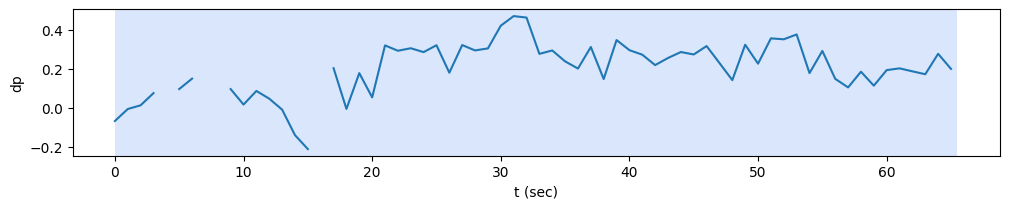

gamma=1 ----- found 1 POCs at 21


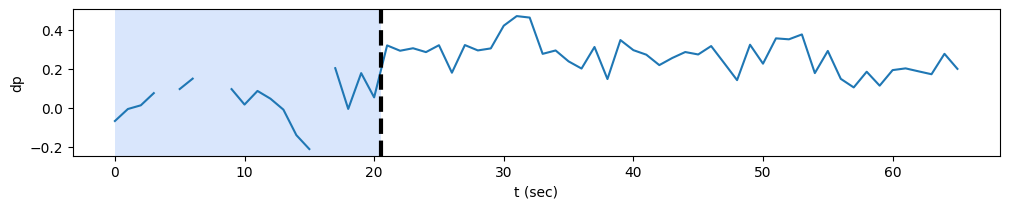

gamma=2 ----- found 1 POCs at 21


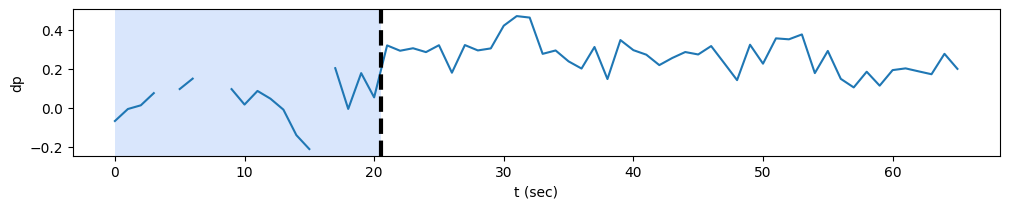

gamma=3 ----- found 1 POCs at 21


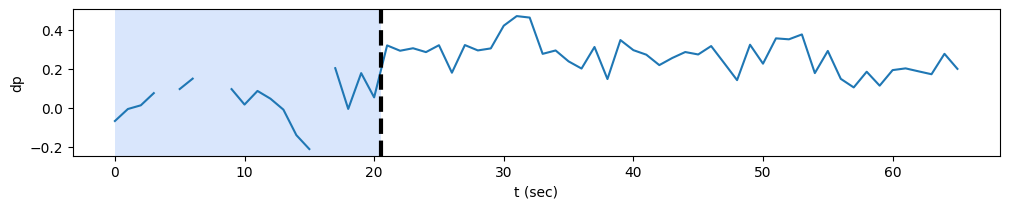

gamma=4 ----- found 1 POCs at 21


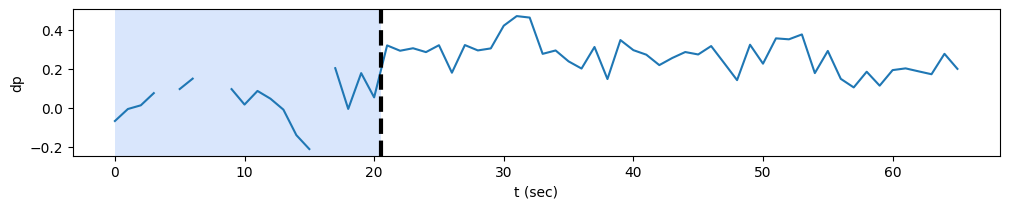

gamma=5 ----- found 1 POCs at 21


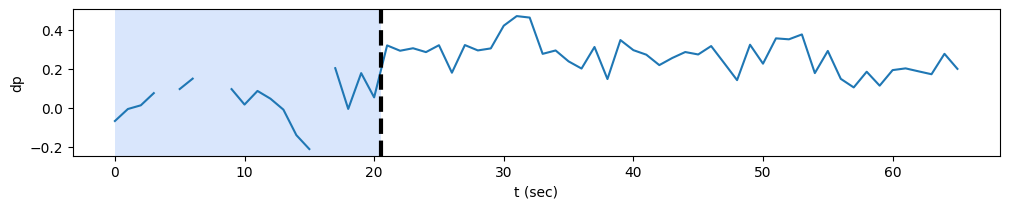

gamma=6 ----- found 1 POCs at 21


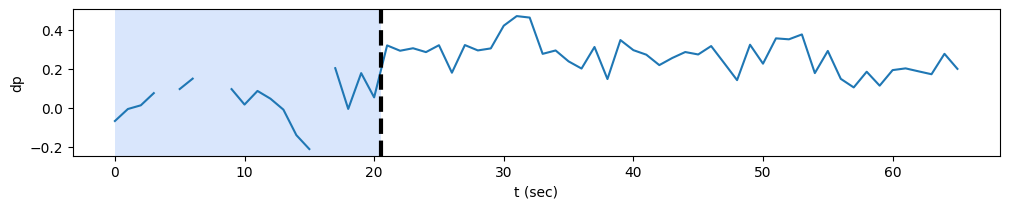

gamma=7 ----- found 2 POCs at 21


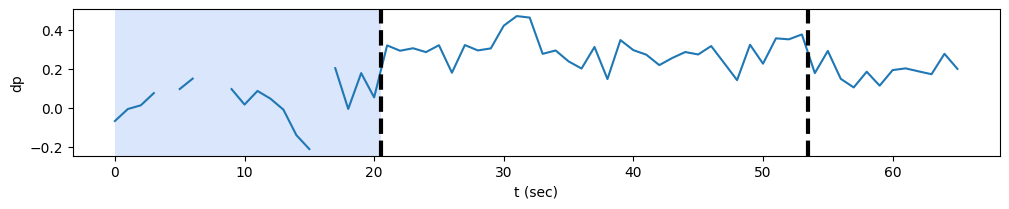

gamma=8 ----- found 2 POCs at 21


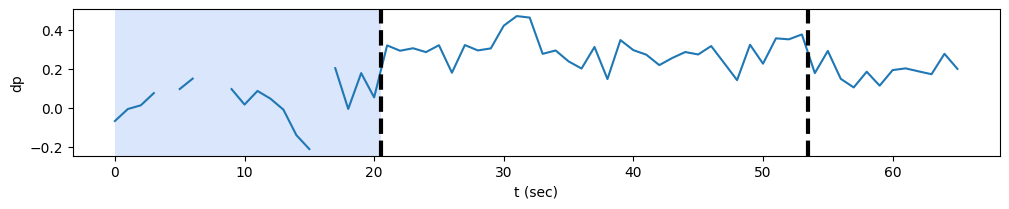

gamma=9 ----- found 4 POCs at 14


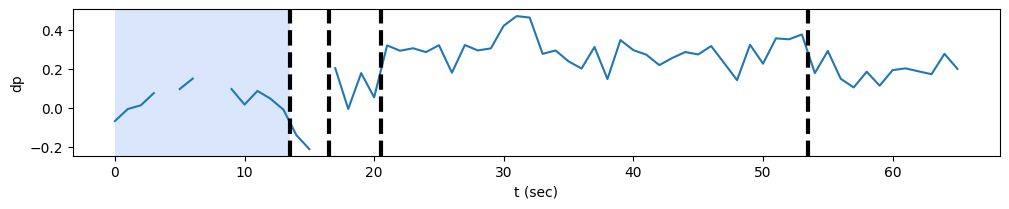

gamma=10 ----- found 4 POCs at 14


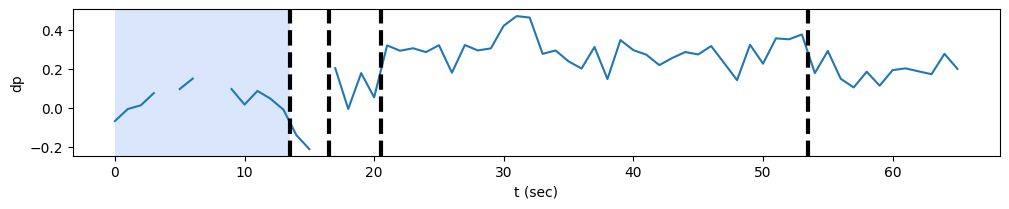

In [156]:
for gamma in range(11):# gamma = 1
  algo = rpt.KernelCPD('rbf', params={'gamma':gamma})
  algo.fit(flare["dpar_detrended"].fillna(method="ffill").values)
  result = algo.predict(pen=1)
  poc_kcpd = result[0]
  print(f"gamma={gamma} ----- found {len(result) - 1} POCs at {poc_kcpd}")
  # display
  rpt.display(flare["dpar_detrended"], [poc_kcpd], result);
  plt.xlabel('t (sec)')
  plt.ylabel('dp');
  plt.show()

with $\gamma<7$ we find a single point of change at the 23rd datapoint.  Increasing $7<=\gamma<10$ we find two, three, and four points of change, the first still at the 21st datapoint which is consistent with the earlier analysis.
